# Team Topic Thunder
### CS 410, Fall 2021

# Topic Model Evaluation

Mine topics of CS 410 course projects for a range of k = number of topics.

Next, generate a model with optimal k, and use the pyLDAvis library to visualize topic coverage and overlap.

Finally, edit `LDA.py` to produce the final output for the [Topic Thunder web app](https://topic-thunder-a7103.web.app/) to consume

## Step 1: Import Packages and Cleaned Text

Note that this doesn't include code for text preprocessing. That's done as a separate step in `text_cleaning.py`. That script removes high-usage words such as "project" and "report" that don't represent the focus of CS 410 projects.

### Ignore deprecation warnings and import required packages

In [1]:
import pandas as pd
from ast import literal_eval #to convert file from a string as we are reading from .tsv

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import cleaned project text, and build a dictionary and document-term matrix

In [3]:
# Import cleaned text
df=pd.read_csv('../project_clean_text.tsv',sep='\t',converters={'clean_text': literal_eval})
df.head()

,project_url,file_text,clean_text
0,https://github.com/17JamesH/CourseProject,project progress report team member task progr...,"[remaining, risk, james, crawling, redfin, wor..."
1,https://github.com/97agupta/CourseProject,team 'buddie' project proposal 1. what are the...,"[buddie, proposal, netids, administrative, dut..."
2,https://github.com/AShipway/CourseProject,aaron shipway cs 410 fall '21 project progress...,"[aaron, shipway, fall, completed, established,..."
3,https://github.com/AlexZurski/CourseProject,alexander zurawski azuraws2 cs 410 11/15/2021 ...,"[alexander, zurawski, azuraws, final, complete..."
4,https://github.com/AnantSharma18/CourseProject,page 1 of 2 project progress report anant ashu...,"[anant, ashutosh, sharma, anantas, edu, indivi..."


## Step 2: Form Bigrams

Identify frequent pairs of words. Bigrams should easier for human readers to interpret than unigrams are.

Code copied and adapted from [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [4]:
# Get cleaned text as list for further processing.

clean_text = df['clean_text'].to_list()

In [5]:
# Build bigram model. Set min_count and threshold arguments arbitrarily.
# These are hyperparameters, so would have to be learned to achieve more targeted values.

bigram = Phrases(clean_text, min_count=5, threshold=15)
bigram_phraser = Phraser(bigram)

In [6]:
# Finally, create bigrammed version of clean_text for further processing.

megalist = [bigram_phraser[doc] for doc in clean_text]

## Step 3: Generate Dictionary and Corpus

In [7]:
# creating a dictionary from the list of lists
dictionary=corpora.Dictionary(megalist)

In [8]:
# Term Document Frequency
doc_term_matrix = [dictionary.doc2bow(doc, allow_update=True) for doc in megalist]

## Step 4: Generate Models

Generate models for a range of k = number of topics.

Also compute perplexity and coherence scores for each model.

Again, code borrowed from [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [9]:
# Routine to generate and score models for a range of k.

def generate_and_score_models(dictionary, corpus, texts, limit, start=2, step=2, random_state=100, alpha="auto"):
    """
   Generate topic models for a range of topic counts.
   Evaluate coherence for each topic count, and return lists.

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity_values: The log of the perplexity of the corresponding LDA model.
    """
    model_list = []
    coherence_values = []
    log_perplexity_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics, 
                         random_state=random_state,  # For repeatability
                         passes=10,
                         iterations=50,
                         alpha=alpha)  # Use "auto" to learn the document-topic distribution
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        log_perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, log_perplexity_values

In [10]:
# Generate models for the given range of k

start = 2
step = 2
limit = 40

model_list, coherence_values, log_perplexity_values = generate_and_score_models(dictionary=dictionary,
                                                                                corpus=doc_term_matrix,
                                                                                texts=megalist,
                                                                                limit=limit,
                                                                                start=start,
                                                                                step=step,
                                                                                random_state=100,
                                                                                alpha="auto")

## Step 3: Review Results

### Review coherence scores

Topic coherence is partly based on the conditional likelihood of co-occurrence of words in a topic. Coherence helps to measure how well-related a topic's words are to each other. For more, see the article [Topic Model Evaluation](https://highdemandskills.com/topic-model-evaluation).

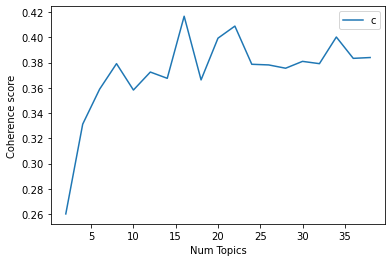

In [11]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
for k, cv in zip(x, coherence_values):
    print("Num Topics =", k, "has Coherence Value of", round(cv, 4))

Num Topics = 2 has Coherence Value of 0.26
Num Topics = 4 has Coherence Value of 0.3312
Num Topics = 6 has Coherence Value of 0.3589
Num Topics = 8 has Coherence Value of 0.3792
Num Topics = 10 has Coherence Value of 0.3583
Num Topics = 12 has Coherence Value of 0.3725
Num Topics = 14 has Coherence Value of 0.3676
Num Topics = 16 has Coherence Value of 0.4168
Num Topics = 18 has Coherence Value of 0.3663
Num Topics = 20 has Coherence Value of 0.3994
Num Topics = 22 has Coherence Value of 0.409
Num Topics = 24 has Coherence Value of 0.3787
Num Topics = 26 has Coherence Value of 0.3782
Num Topics = 28 has Coherence Value of 0.3756
Num Topics = 30 has Coherence Value of 0.381
Num Topics = 32 has Coherence Value of 0.3792
Num Topics = 34 has Coherence Value of 0.4003
Num Topics = 36 has Coherence Value of 0.3834
Num Topics = 38 has Coherence Value of 0.384


Coherence rises to a local peak at 8 topics, then hits a higher peak at 16 topics before bouncing around within a narrow range of values.

It's common practice to pick the first model that hits peak coherence before plateauing.

### Review log-perplexity scores

Topic perplexity is proportional to the inverse probability of a test set against the topics mined from a training set. Perplexity is computed from held-out data. A lower perplexity reflects a better topic model. For more, see the article [Perplexity in Language Models](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94).

However, the article [Topic Model Evaluation](https://highdemandskills.com/topic-model-evaluation) suggests that models with better perplexity scores are harder for humans to interpret.

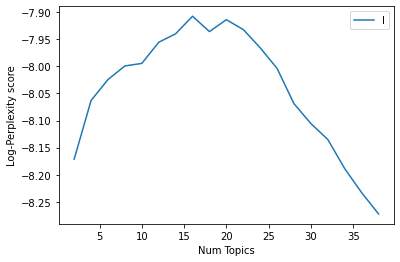

In [12]:
x = range(start, limit, step)
plt.plot(x, log_perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Log-Perplexity score")
plt.legend(("log_perplexity_values"), loc='best')
plt.show()

In [13]:
for k, lpv in zip(x, log_perplexity_values):
    print("Num Topics =", k, "has Log-Perplexity Value of", round(lpv, 4))

Num Topics = 2 has Log-Perplexity Value of -8.1713
Num Topics = 4 has Log-Perplexity Value of -8.063
Num Topics = 6 has Log-Perplexity Value of -8.0244
Num Topics = 8 has Log-Perplexity Value of -7.9994
Num Topics = 10 has Log-Perplexity Value of -7.9947
Num Topics = 12 has Log-Perplexity Value of -7.9558
Num Topics = 14 has Log-Perplexity Value of -7.9401
Num Topics = 16 has Log-Perplexity Value of -7.9078
Num Topics = 18 has Log-Perplexity Value of -7.936
Num Topics = 20 has Log-Perplexity Value of -7.9142
Num Topics = 22 has Log-Perplexity Value of -7.9323
Num Topics = 24 has Log-Perplexity Value of -7.9659
Num Topics = 26 has Log-Perplexity Value of -8.004
Num Topics = 28 has Log-Perplexity Value of -8.069
Num Topics = 30 has Log-Perplexity Value of -8.1056
Num Topics = 32 has Log-Perplexity Value of -8.1349
Num Topics = 34 has Log-Perplexity Value of -8.1887
Num Topics = 36 has Log-Perplexity Value of -8.2329
Num Topics = 38 has Log-Perplexity Value of -8.2721


As we're aiming for low log-perplexity, the only options seem to be models with 2 topics, or 34 or more. Since low-perplexity topic models can be harder for humans to interpret, and CS 410 projects cover more than 2 topics, we'll focus more on coherence.

### Examine highlighted topic models

Review the models highlighted by the coherence scores: the models with 8 and 16 topics.

View the topics themselves, and generate pyLDAvis breakdowns to help gauge topic sizes and degrees of overlap.

In pyLDAvis, overlap or close proximity of topics indicates high similarity. Generally, we should look for models with well-separated topics. For more information, see [pyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know).

#### 8-topic model

Topics
* 0: Frequent-pattern mining; possible contextual text mining
* 1: Topic modeling; text classification
* 2: Topic modeling; text retrieval, possibly in the context of faculty homepages
* 3: Topic modeling; text/document collections; time series
* 4: Possible contextual text mining; sentiment analysis; BERT
* 5: Twitter sarcasm analysis; text classification; BERT
* 6: Topic modeling; possible system extension; Chrome extension
* 7: Topic modeling; sentiment analysis, possibly in the context of stock-market data; BERT

In [14]:
# Model with 8 topics
pprint(model_list[3].print_topics(num_words=10))

[(0,
  '0.022*"pattern" + 0.008*"frequent_pattern" + 0.007*"text" + 0.007*"context" '
  '+ 0.006*"model" + 0.005*"context_unit" + 0.005*"system" + '
  '0.004*"transaction" + 0.004*"search" + 0.004*"term"'),
 (1,
  '0.022*"model" + 0.009*"topic" + 0.008*"classifier" + 0.007*"text" + '
  '0.005*"algorithm" + 0.005*"document" + 0.004*"library" + '
  '0.004*"text_classification" + 0.004*"feature" + 0.004*"step"'),
 (2,
  '0.012*"topic" + 0.011*"model" + 0.010*"document" + 0.008*"url" + '
  '0.007*"search" + 0.006*"system" + 0.006*"text" + 0.006*"information" + '
  '0.005*"faculty" + 0.005*"time"'),
 (3,
  '0.019*"model" + 0.017*"topic" + 0.008*"text" + 0.007*"collection" + '
  '0.005*"time_series" + 0.005*"document" + 0.005*"algorithm" + 0.004*"common" '
  '+ 0.004*"two" + 0.004*"time"'),
 (4,
  '0.024*"model" + 0.006*"text" + 0.005*"context" + 0.005*"label" + '
  '0.004*"import" + 0.004*"sentiment" + 0.004*"bert" + 0.004*"score" + '
  '0.004*"player" + 0.004*"prediction"'),
 (5,
  '0.070*

pyLDAvis output for 8 topics

Topics 0, 1, 4 and 5 show good separation. Remaining models show overlap.

Since some topics appear rather generic (like topic 1), continue on to the 16-topic model.

In [15]:
pyLDAvis.enable_notebook()
vis_8_topics = pyLDAvis.gensim_models.prepare(model_list[3], doc_term_matrix, dictionary=model_list[3].id2word)
vis_8_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.069609  0.026962       1        1  24.767700
3     -0.095159  0.055822       2        1  15.465460
5      0.156411 -0.017073       3        1  12.816108
6     -0.020949  0.052767       4        1  12.402389
7     -0.035130  0.043002       5        1   9.405569
0     -0.084423 -0.158657       6        1   9.042863
1      0.057273  0.019246       7        1   8.637723
4      0.091586 -0.022069       8        1   7.462189, topic_info=                 Term         Freq        Total Category  logprob  loglift
1917  twitter_sarcasm  2246.000000  2246.000000  Default  30.0000  30.0000
1080          twitter  1795.000000  1795.000000  Default  29.0000  29.0000
2533          pattern   545.000000   545.000000  Default  28.0000  28.0000
353             model  4597.000000  4597.000000  Default  27.0000  27.0000
1754             bert   798.000000   798.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
299    implementation    46.896444   489.931589   Topic8  -5.9873   0.2490
505               two    48.065355   562.368686   Topic8  -5.9627   0.1357
484              step    48.393992   626.897267   Topic8  -5.9559   0.0339
1080          twitter    53.326890  1795.249128   Topic8  -5.8588  -0.9211
269             first    45.021525   524.814929   Topic8  -6.0281   0.1394

[640 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
14775      1  0.983679    _________
9850       8  0.942124      _player
12536      8  0.963411          acc
748        1  0.140253     accuracy
748        2  0.045488     accuracy
...      ...       ...          ...
16066      6  0.950139      xlocale
8606       8  0.948496  xml_roberta
16887      3  0.931428      xuechen
12750      8  0.971879       y_pred
4653       4  0.905531         yarn

[1737 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 7, 8, 1, 2, 5])

_Screenshot of pyLDAvis output for 8-topic model_
![Screenshot of pyLDAvis output for 8-topic model](08_topic_model_pyLDAvis_overall.png)

#### 16-topic model

Topics
* 0: Possible text analysis in the context of course lectures
* 1: Topic modeling; text classification, possibly in the context of medical data
* 2: Topic modeling; text retrieval, possibly in the context of faculty homepages
* 3: Topic modeling; time series; causal topic modeling
* 4: Aspect rating analysis
* 5: Twitter sarcasm detection; sentiment analy
* 6: Document collection; topic modeling; document clustering
* 7: Topic search; system extension; possibly in the context of course lectures
* 8: BERT and Tensorflow; possible focus on model performance
* 9: Search/ElasticSearch; MetaPy; application
* 10: Topic modeling; search; recommendation; possibly in the context of movies
* 11: Frequent-pattern mining; contextual text analysis
* 12: Text classification; competition-centered projects; BERT
* 13: Model bias and accuracy; BERT; possible time-series analysis
* 14: Sentiment analysis, possibly in the context of tweets about stock-market prices
* 15: Topic modeling; text/document search; system extension; Chrome extension

In [16]:
# Model with 16 topics
pprint(model_list[7].print_topics(num_words=10))

[(0,
  '0.010*"text" + 0.006*"topic" + 0.006*"algorithm" + 0.006*"lecture" + '
  '0.006*"search" + 0.005*"score" + 0.004*"product" + 0.004*"implement" + '
  '0.004*"system" + 0.004*"information"'),
 (1,
  '0.016*"topic" + 0.008*"algorithm" + 0.007*"model" + 0.007*"classifier" + '
  '0.006*"document" + 0.005*"text" + 0.005*"note" + 0.005*"patient" + '
  '0.005*"edu" + 0.004*"created"'),
 (2,
  '0.016*"model" + 0.013*"url" + 0.012*"topic" + 0.011*"document" + '
  '0.009*"faculty" + 0.007*"system" + 0.006*"information" + 0.006*"text" + '
  '0.006*"search" + 0.005*"classifier"'),
 (3,
  '0.028*"topic" + 0.011*"time_series" + 0.007*"text" + 0.007*"model" + '
  '0.006*"prior" + 0.006*"topic_modeling" + 0.006*"document" + '
  '0.005*"algorithm" + 0.005*"function" + 0.005*"causal_topic"'),
 (4,
  '0.019*"model" + 0.017*"aspect" + 0.012*"lara" + 0.012*"aspect_rating" + '
  '0.010*"lrr" + 0.009*"rating" + 0.008*"step" + 0.007*"wang" + '
  '0.007*"function" + 0.007*"hongning_wang"'),
 (5,
  '0.25

pyLDAvis output for 16 topics

Topics 4, 5, 6, 9, 11 and 13 appear separate from the others. The remaining topics overlap in two separate clusters.

It's reasonable to expect that CS 410 projects will cover much of the same ground even when they have different focus.

In [17]:
vis_16_topics = pyLDAvis.gensim_models.prepare(model_list[7], doc_term_matrix, dictionary=model_list[7].id2word)
vis_16_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.105249  0.016744       1        1  15.090090
14     0.047168 -0.031369       2        1  14.185977
2      0.063037 -0.011512       3        1  12.817451
15     0.094349 -0.036327       4        1  12.416933
6      0.016529  0.115556       5        1   9.478012
3      0.082324  0.019717       6        1   6.957602
11     0.009260  0.201244       7        1   4.420022
7      0.074272 -0.030909       8        1   4.038221
1      0.027481  0.009167       9        1   3.663220
10     0.065387 -0.025149      10        1   3.615539
8     -0.123664  0.018331      11        1   3.287509
5     -0.274231 -0.067811      12        1   3.020996
13    -0.031096 -0.018721      13        1   2.216385
9      0.059532 -0.158857      14        1   1.969173
0      0.028510 -0.028505      15        1   1.554105
4     -0.033609  0.028402      16        1   1.268764, topic_info=                 Term         Freq        Total Category  logprob  loglift
1917  twitter_sarcasm  1915.000000  1915.000000  Default  30.0000  30.0000
1080          twitter  1597.000000  1597.000000  Default  29.0000  29.0000
353             model  4699.000000  4699.000000  Default  28.0000  28.0000
2533          pattern   556.000000   556.000000  Default  27.0000  27.0000
1754             bert   819.000000   819.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
997        prediction    12.872409   362.898985  Topic16  -5.5083   1.0281
513             value    12.586286   375.910606  Topic16  -5.5308   0.9704
497           testing    12.296484   428.749737  Topic16  -5.5541   0.8156
601     search_engine    11.911936   199.353555  Topic16  -5.5859   1.5496
392         parameter    11.919666   491.327152  Topic16  -5.5852   0.6482

[1193 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
14775      3  0.966734    _________
9850       2  0.950433      _player
3810       6  0.871530        aamrq
141        1  0.092134         able
141        2  0.184269         able
...      ...       ...          ...
1738       8  0.133367  zhai_latent
1738      10  0.044456  zhai_latent
1738      16  0.711290  zhai_latent
17136     13  0.718639       zhihao
1740      16  0.911644   ziyuan_wei

[4475 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 15, 3, 16, 7, 4, 12, 8, 2, 11, 9, 6, 14, 10, 1, 5])

_Screenshot of pyLDAvis output for 16-topic model_
![Screenshot of pyLDAvis output for 16-topic model](16_topic_model_pyLDAvis_overall.png)

## Step 4: Choose Optimal Model and Output Its Document/Topic Relationships

The frequent-pattern mining theme and the Twitter sarcasm-detection theme appeared for both examined models.

Some other topics have grown more detailed as k increased.

All other things being equal, the 16-topic model has the highest coherence score. Most of the topics overlap, but it's reasonable for CS 410 projects to share common concepts, approaches and tools, even when their aims differ.

We'll consider the 16-topic model to be optimal.

In [18]:
optimal_model = model_list[7]

### Identify the dominant topic in each CS 410 project

Once again, code borrowed from [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [19]:
def format_topics_docs(ldamodel, corpus, texts):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


df_topic_docs_keywords = format_topics_docs(ldamodel=optimal_model, corpus=doc_term_matrix, texts=megalist)

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

# Show
df_dominant_topic.head(10)

,document_no,dominant_topic,topic_perc_contrib,keywords,text
0,0,3.0,0.9982,"topic, time_series, text, model, prior, topic_...","[remaining, risk, james, crawling, redfin, wor..."
1,1,3.0,0.7353,"topic, time_series, text, model, prior, topic_...","[buddie, proposal_netids, administrative_duty,..."
2,2,15.0,0.6400,"topic, text, model, extension, search, documen...","[aaron, shipway, fall, completed, established,..."
3,3,15.0,0.7151,"topic, text, model, extension, search, documen...","[alexander, zurawski, azuraws, final, complete..."
4,4,2.0,0.7469,"model, url, topic, document, faculty, system, ...","[anant, ashutosh, sharma, anantas, edu, indivi..."
5,5,3.0,0.8358,"topic, time_series, text, model, prior, topic_...","[paste_cmt, detailed_instruction, activity]"
6,6,13.0,0.5357,"model, bias, complete, bert, text, time, label...","[reddit, recommenders, completed, divided, amo..."
7,7,14.0,0.5856,"sentiment, sentiment_analysis, twitter, stock,...","[proposal, song, retrieval, sentiment_analysis..."
8,8,3.0,0.7311,"topic, time_series, text, model, prior, topic_...","[andrew, sciotti, sciotti, completed, complete..."
9,9,15.0,0.7715,"topic, text, model, extension, search, documen...","[completed, frontend, completed, created, chro..."


### Identify the most representative document for each topic

In [23]:
doc_topics_sorted_df = pd.DataFrame()

doc_topics_grouped = df_topic_docs_keywords.groupby('dominant_topic')

for i, grp in doc_topics_grouped:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index
doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorted_df.columns = ['topic_num', "topic_perc_contrib", "keywords", "text"]

# Show
doc_topics_sorted_df.head(len(doc_topics_sorted_df))

,topic_num,topic_perc_contrib,keywords,text
0,0.0,0.9976,"text, topic, algorithm, lecture, search, score...","[experience, profile, resume, high_level, comp..."
1,1.0,0.9998,"topic, algorithm, model, classifier, document,...","[final, topic, mining, healthcare, completed, ..."
2,2.0,0.9999,"model, url, topic, document, faculty, system, ...","[improving, expertsearch, plan, automate, scra..."
3,3.0,0.9998,"topic, time_series, text, model, prior, topic_...","[mining_causal, topic, text_iterative, topic_m..."
4,4.0,0.9994,"model, aspect, lara, aspect_rating, lrr, ratin...","[reproducing_latent, aspect_rating, analysis, ..."
5,5.0,0.9999,"twitter_sarcasm, twitter, model, evaluation, b...","[topic, bert, sentiment_analysis, detect, twit..."
6,6.0,0.9998,"model, collection, document, text, common, min...","[cross_collection, model, comparative_text, mi..."
7,7.0,0.9995,"system, topic, search, lecture, text, current,...","[matt, williamson, mdw, lead, november, metapy..."
8,8.0,0.9999,"model, document, bert, score, text, parameter,...","[cody_webster, made_thus, far, generic, wrote,..."
9,9.0,0.9997,"search, app, elasticsearch, metapy, applicatio...","[search_engine, indoor_environment, elasticsea..."


## Where to Go From Here

Edit `LDA.py` to produce final output files `AlgOutput.tsv`and `firebase-output.json`. The JSON file is for the [Topic Thunder web app](https://topic-thunder-a7103.web.app/) to consume. 

To edit `LDA.py`, update its call to GenSim LdaModel with the same settings that produced the optimal model above.